# Car Price prediction

<img src="https://whatcar.vn/media/2018/09/car-lot-940x470.jpg"/>

## Прогнозирование стоимости автомобиля по характеристикам


In [1]:
# Установим модули
!pip install -q tensorflow==2.3
!pip install albumentations -q
!pip install pymorphy2
!pip install pymorphy2-dicts

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
     |████████████████████████████████| 55 kB 574 kB/s 
     |████████████████████████████████| 8.2 MB 8.1 MB/s 
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
     |████████████████████████████████| 7.1 MB 6.4 MB/s 
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
# импортиурем необходимые библиотеки
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras.layers as L
import albumentations
import matplotlib.pyplot as plt
import seaborn as sns
import pymorphy2
import os
import sys
import PIL
import cv2
import re

from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from pylab import rcParams
from itertools import combinations
from scipy.stats import ttest_ind

print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)

Python       : 3.7.6 | packaged by conda-forge | (default, Mar 23 2020, 23:03:20) 
Numpy        : 1.18.5
Tensorflow   : 2.3.0


In [3]:
# параметры и фиксация рандом сида
rcParams['figure.figsize'] = 10, 5
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

!pip freeze > requirements.txt

In [4]:
# MAPE функция
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

In [5]:
DATA_DIR = '../input/sf-dst-car-price-prediction-part2/'
train = pd.read_csv(DATA_DIR + 'train.csv')
test = pd.read_csv(DATA_DIR + 'test.csv')
sample_submission = pd.read_csv(DATA_DIR + 'sample_submission.csv')

## Наивная модель

In [6]:
# построим наивную модель и будем сравнивать её с дальнейшими результатами
data_train, data_test = train_test_split(
    train,
    test_size=0.15,
    shuffle=True,
    random_state=RANDOM_SEED
)

In [7]:
predicts = []

for index, row in pd.DataFrame(
    data_test[['model_info', 'productionDate']]
).iterrows():
    query = f"model_info == '{row[0]}' and productionDate == '{row[1]}'"
    predicts.append(data_train.query(query)['price'].median())
    
predicts = pd.DataFrame(predicts)
predicts = predicts.fillna(predicts.median())
predicts = (predicts // 1000) * 1000

print(f"MAPE for Naive Forecasting: {(mape(data_test['price'], predicts.values[:, 0]))*100:0.2f}%")

MAPE for Naive Forecasting: 19.88%


## EDA

In [8]:
train.info()
train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6682 entries, 0 to 6681
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              6682 non-null   object 
 1   brand                 6682 non-null   object 
 2   color                 6682 non-null   object 
 3   description           6682 non-null   object 
 4   engineDisplacement    6682 non-null   object 
 5   enginePower           6682 non-null   object 
 6   fuelType              6682 non-null   object 
 7   mileage               6682 non-null   int64  
 8   modelDate             6682 non-null   int64  
 9   model_info            6682 non-null   object 
 10  name                  6682 non-null   object 
 11  numberOfDoors         6682 non-null   int64  
 12  price                 6682 non-null   float64
 13  productionDate        6682 non-null   int64  
 14  sell_id               6682 non-null   int64  
 15  vehicleConfiguration 

,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_info,...,price,productionDate,sell_id,vehicleConfiguration,vehicleTransmission,Владельцы,Владение,ПТС,Привод,Руль
0,седан,BMW,чёрный,Авто на бодром ходу. Все работает отлично. П...,3.0 LTR,272 N12,бензин,245000,2007,5ER,...,599000.0,2007,1099980990,SEDAN AUTOMATIC 3.0,автоматическая,3 или более,NaN,Оригинал,полный,Левый
1,седан,AUDI,серебристый,"Продажа от собственника, второй владелец, ПТС ...",2.8 LTR,204 N12,бензин,183000,2011,A6,...,850000.0,2011,1095836906,SEDAN VARIATOR 2.8,вариатор,2 владельца,8 лет и 6 месяцев,Оригинал,передний,Левый
2,седан,MERCEDES,чёрный,Внимание! Только для клиентов AVILON Автомобил...,3.5 LTR,306 N12,бензин,122733,2009,E_KLASSE,...,1325000.0,2013,1100195530,SEDAN AUTOMATIC 3.5,автоматическая,3 или более,NaN,Оригинал,полный,Левый
3,седан,AUDI,белый,В комплекте зимние колёса. 27.07.2020 Замена п...,2.0 LTR,180 N12,бензин,151000,2011,A6,...,815000.0,2011,1099880662,SEDAN VARIATOR 2.0,вариатор,3 или более,4 года и 9 месяцев,Оригинал,передний,Левый
4,лифтбек,AUDI,белый,"Отличный авто, 2011 года выпуска, кроме передн...",1.8 LTR,160 N12,бензин,140000,2007,A5,...,810000.0,2011,1083244610,LIFTBACK VARIATOR 1.8,вариатор,3 или более,2 года и 9 месяцев,Оригинал,передний,Левый


In [9]:
# есть смысл убрать столбец Владение и добавить недостающее значение в графу Владельцы
train[train['Владельцы'].isna()]


,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_info,...,price,productionDate,sell_id,vehicleConfiguration,vehicleTransmission,Владельцы,Владение,ПТС,Привод,Руль
4994,седан,AUDI,чёрный,машина в идеале! вложено примерно 400тыс.руб \...,4.2 LTR,360 N12,бензин,160000,1999,S8,...,600000.0,2001,1019330519,SEDAN AUTOMATIC 4.2,автоматическая,NaN,10 лет и 7 месяцев,Оригинал,полный,Левый


In [10]:
train.loc[train['Владельцы'].isna()==True, 'Владельцы'] = '3 или более'

In [11]:
test.info()
test.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1671 entries, 0 to 1670
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   bodyType              1671 non-null   object
 1   brand                 1671 non-null   object
 2   color                 1671 non-null   object
 3   description           1671 non-null   object
 4   engineDisplacement    1671 non-null   object
 5   enginePower           1671 non-null   object
 6   fuelType              1671 non-null   object
 7   mileage               1671 non-null   int64 
 8   modelDate             1671 non-null   int64 
 9   model_info            1671 non-null   object
 10  name                  1671 non-null   object
 11  numberOfDoors         1671 non-null   int64 
 12  productionDate        1671 non-null   int64 
 13  sell_id               1671 non-null   int64 
 14  vehicleConfiguration  1671 non-null   object
 15  vehicleTransmission   1671 non-null   

,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_info,...,numberOfDoors,productionDate,sell_id,vehicleConfiguration,vehicleTransmission,Владельцы,Владение,ПТС,Привод,Руль
0,универсал 5 дв.,MERCEDES,чёрный,Всем привет!\n\nПродам эксклюзивный проект 124...,3.0 LTR,220 N12,бензин,350000,1984,W124,...,5,1991,1099427284,WAGON_5_DOORS AUTOMATIC 3.0,автоматическая,3 или более,6 лет и 3 месяца,Оригинал,задний,Левый
1,купе,BMW,белый,Продаю любимейшую тачилу.. Обвес и тюнинг Hamm...,3.0 LTR,313 N12,дизель,15000,2011,6ER,...,2,2013,1096405886,COUPE AUTOMATIC 3.0,автоматическая,1 владелец,6 лет и 6 месяцев,Оригинал,полный,Левый
2,купе,BMW,пурпурный,"Машина тут продаётся не в первый раз, НО! Толь...",2.5 LTR,218 N12,бензин,166600,2005,3ER,...,2,2008,1100195294,COUPE AUTOMATIC 2.5,автоматическая,3 или более,NaN,Оригинал,полный,Левый
3,седан,BMW,белый,"Автомобиль в отличном состоянии, весь в родной...",2.0 LTR,136 N12,бензин,147000,2005,3ER,...,4,2007,1099827282,SEDAN AUTOMATIC 2.0,автоматическая,2 владельца,NaN,Оригинал,задний,Левый
4,седан,BMW,чёрный,Немка! с бесключивым доступом и камерой заднег...,2.0 LTR,190 N12,дизель,24000,2016,5ER,...,4,2019,1100076198,SEDAN AUTOMATIC 2.0,автоматическая,1 владелец,NaN,Оригинал,полный,Левый


In [12]:
# проверим дубликаты
train.duplicated().value_counts()

False    6682
dtype: int64

In [13]:
test.duplicated().value_counts()

False    1671
dtype: int64

In [14]:
# мерджим таблицы
train['sample'] = 1
test['sample'] = 0
test['price'] = 0

data = test.append(train, sort=False).reset_index(drop=True)

In [15]:
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8353 entries, 0 to 8352
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              8353 non-null   object 
 1   brand                 8353 non-null   object 
 2   color                 8353 non-null   object 
 3   description           8353 non-null   object 
 4   engineDisplacement    8353 non-null   object 
 5   enginePower           8353 non-null   object 
 6   fuelType              8353 non-null   object 
 7   mileage               8353 non-null   int64  
 8   modelDate             8353 non-null   int64  
 9   model_info            8353 non-null   object 
 10  name                  8353 non-null   object 
 11  numberOfDoors         8353 non-null   int64  
 12  productionDate        8353 non-null   int64  
 13  sell_id               8353 non-null   int64  
 14  vehicleConfiguration  8353 non-null   object 
 15  vehicleTransmission  

,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_info,...,sell_id,vehicleConfiguration,vehicleTransmission,Владельцы,Владение,ПТС,Привод,Руль,sample,price
0,универсал 5 дв.,MERCEDES,чёрный,Всем привет!\n\nПродам эксклюзивный проект 124...,3.0 LTR,220 N12,бензин,350000,1984,W124,...,1099427284,WAGON_5_DOORS AUTOMATIC 3.0,автоматическая,3 или более,6 лет и 3 месяца,Оригинал,задний,Левый,0,0.0
1,купе,BMW,белый,Продаю любимейшую тачилу.. Обвес и тюнинг Hamm...,3.0 LTR,313 N12,дизель,15000,2011,6ER,...,1096405886,COUPE AUTOMATIC 3.0,автоматическая,1 владелец,6 лет и 6 месяцев,Оригинал,полный,Левый,0,0.0
2,купе,BMW,пурпурный,"Машина тут продаётся не в первый раз, НО! Толь...",2.5 LTR,218 N12,бензин,166600,2005,3ER,...,1100195294,COUPE AUTOMATIC 2.5,автоматическая,3 или более,NaN,Оригинал,полный,Левый,0,0.0
3,седан,BMW,белый,"Автомобиль в отличном состоянии, весь в родной...",2.0 LTR,136 N12,бензин,147000,2005,3ER,...,1099827282,SEDAN AUTOMATIC 2.0,автоматическая,2 владельца,NaN,Оригинал,задний,Левый,0,0.0
4,седан,BMW,чёрный,Немка! с бесключивым доступом и камерой заднег...,2.0 LTR,190 N12,дизель,24000,2016,5ER,...,1100076198,SEDAN AUTOMATIC 2.0,автоматическая,1 владелец,NaN,Оригинал,полный,Левый,0,0.0


bodyType - категориальный

brand - категориальный

color - категориальный

description - текстовый

engineDisplacement - числовой, представленный как текст

enginePower - числовой, представленный как текст

fuelType - категориальный

mileage - числовой

modelDate - числовой

model_info - категориальный

name - категориальный, желательно сократить размерность

numberOfDoors - категориальный

price - числовой, целевой

productionDate - числовой

sell_id - изображение (файл доступен по адресу, основанному на sell_id)

vehicleConfiguration - не используется (комбинация других столбцов)

vehicleTransmission - категориальный

Владельцы - категориальный

Владение - числовой, представленный как текст

ПТС - категориальный

Привод - категориальный
Руль - категориальный

Пройдемся по ним детальнее

In [16]:
data['bodyType'].value_counts()

седан                   3541
внедорожник 5 дв.       2896
купе                     543
хэтчбек 5 дв.            364
лифтбек                  299
универсал 5 дв.          196
минивэн                  178
купе-хардтоп             111
родстер                   88
хэтчбек 3 дв.             57
кабриолет                 54
компактвэн                 8
лимузин                    5
внедорожник 3 дв.          5
внедорожник открытый       4
пикап двойная кабина       3
седан 2 дв.                1
Name: bodyType, dtype: int64

In [17]:
data['brand'].value_counts()

BMW         3535
MERCEDES    2846
AUDI        1972
Name: brand, dtype: int64

In [18]:
data['color'].value_counts()

чёрный         3468
белый          1607
серый           925
синий           863
серебристый     420
коричневый      386
красный         266
голубой          91
зелёный          86
бежевый          85
фиолетовый       46
пурпурный        38
оранжевый        30
золотистый       24
жёлтый           17
розовый           1
Name: color, dtype: int64

In [19]:
data['description'][0]

'Всем привет!\n\nПродам эксклюзивный проект 124 универсал 300TE-24 SportLine\n\nМодель 124.091 300 TE-24\nДвигатель 104.980\nТрансмиссия 722.359\nЦвет кузова 040 (черный)\nОтделка салона 271 (Кожа черная / "антрацит")\n\nОпции:\n211 Автоматическая блокировка дифференциала (ASD)\n240 Индикатор внешней температуры\n244 Спортивные сиденья спереди\n281 Спортивное рулевое колесо с отделкой из кожи (диаметр 390 мм) и кожаный рычаг КПП\n291 Подушка безопасности для водителя и переднего пассажира\n300 Дополнительный бардачок в вещевом отсеке спереди\n412 Люк с электроприводом и устройством подъёма\n420 Автоматическая коробка передач, напольное исполнение\n440 Темпомат (круиз-контроль)\n538 Автоматическая антенна\n541 Двойные занавески для багажного пространства и пасажирского отсека (сетка/шторка)\n570 Складной подлокотник спереди\n586 Кондиционер Behr и электрические стеклоподъемники передних и задних дверей\n598 Атермальные боковые и заднее стекла, заднее стекло с подогревом (ESG)\n650 Спорт

In [20]:
data['engineDisplacement'].value_counts()

2.0 LTR          2430
3.0 LTR          2349
1.8 LTR           411
1.6 LTR           410
4.4 LTR           329
5.5 LTR           268
3.5 LTR           250
2.5 LTR           248
2.1 LTR           221
4.0 LTR           153
4.7 LTR           137
1.4 LTR           106
2.8 LTR           106
4.2 LTR           103
5.0 LTR            74
1.5 LTR            73
3.2 LTR            60
2.2 LTR            58
4.8 LTR            57
2.9 LTR            50
3.1 LTR            44
2.4 LTR            44
6.2 LTR            40
6.0 LTR            37
5.4 LTR            33
1.2 LTR            33
1.3 LTR            32
2.7 LTR            24
4.1 LTR            23
3.6 LTR            23
1.7 LTR            15
2.3 LTR            14
3.7 LTR            14
5.2 LTR            13
5.9 LTR            11
2.6 LTR             9
undefined LTR       6
0.7 LTR             6
5.8 LTR             5
6.6 LTR             5
4.6 LTR             5
1.9 LTR             5
4.3 LTR             4
3.4 LTR             4
5.6 LTR             3
6.3 LTR   

In [21]:
data[data['engineDisplacement'] == 'undefined LTR']

,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_info,...,sell_id,vehicleConfiguration,vehicleTransmission,Владельцы,Владение,ПТС,Привод,Руль,sample,price
1005,хэтчбек 5 дв.,BMW,серебристый,.,undefined LTR,170 N12,электро,89942,2013,I3,...,1100166318,HATCHBACK_5_DOORS AUTOMATIC,автоматическая,1 владелец,NaN,Оригинал,задний,Левый,0,0.0
3967,хэтчбек 5 дв.,BMW,чёрный,"Автомобиль в наличии Москве , с ПТС , производ...",undefined LTR,184 N12,электро,9000,2017,I3,...,1100083262,HATCHBACK_5_DOORS AUTOMATIC,автоматическая,1 владелец,NaN,Оригинал,задний,Левый,1,2719000.0
5396,хэтчбек 5 дв.,BMW,чёрный,"BMW i3 Электромобиль с бензиновым генератором,...",undefined LTR,170 N12,электро,39500,2017,I3,...,1098041130,HATCHBACK_5_DOORS AUTOMATIC,автоматическая,1 владелец,2 года и 11 месяцев,Оригинал,задний,Левый,1,2299711.0
5397,хэтчбек 5 дв.,BMW,голубой,Прибыло из Америки в августе 20 года. Полная и...,undefined LTR,170 N12,электро,28800,2017,I3,...,1100097316,HATCHBACK_5_DOORS AUTOMATIC,автоматическая,1 владелец,NaN,Оригинал,задний,Левый,1,2170000.0
7533,хэтчбек 5 дв.,BMW,белый,В наличии! Автомобиль куплен в США! Комплектац...,undefined LTR,170 N12,электро,35810,2013,I3,...,1100153696,HATCHBACK_5_DOORS AUTOMATIC,автоматическая,1 владелец,NaN,Оригинал,задний,Левый,1,1690000.0
7954,хэтчбек 5 дв.,BMW,чёрный,Авто в идеальном состоянии\nЕсть REX (range ex...,undefined LTR,170 N12,электро,60000,2013,I3,...,1097395090,HATCHBACK_5_DOORS AUTOMATIC,автоматическая,1 владелец,NaN,Оригинал,задний,Левый,1,1790000.0


In [22]:
# поискав в интернете принял решение, что эта модель пойдет на 1.3 лтр
data.loc[data['engineDisplacement'] == 'undefined LTR', 'engineDisplacement'] = '1.3 LTR'

In [23]:
# для дальнейшего логарифмирования есть смысл умножить всё на тысячу (миллилитры)
data['engineDisplacement'] = data['engineDisplacement'].str.split().apply(
    lambda s: s[0]
)

data['engineDisplacement'] = data['engineDisplacement'].apply(
    lambda s: float(s)
)

data['engineDisplacement'] = data['engineDisplacement']*1000

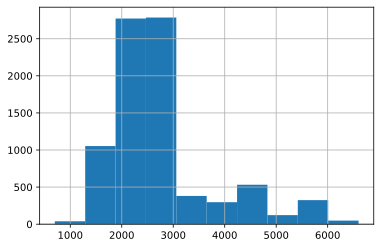

In [24]:
data['engineDisplacement'].hist()

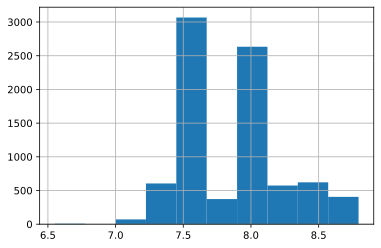

In [25]:
np.log(data['engineDisplacement']).hist()

стало лучше

In [26]:
data['enginePower'].value_counts()

184 N12    759
249 N12    655
190 N12    420
245 N12    355
306 N12    344
          ... 
98 N12       1
101 N12      1
457 N12      1
329 N12      1
132 N12      1
Name: enginePower, Length: 154, dtype: int64

In [27]:
# переведем в числа и логарифмирурем 
data['enginePower'] = data['enginePower'].str.split().apply(
    lambda s: s[0]
)

data['enginePower'] = data['enginePower'].apply(
    lambda s: float(s)
)

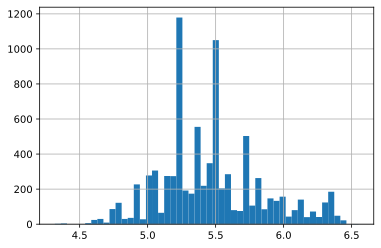

In [28]:
np.log(data['enginePower']).hist(bins=50)

In [29]:
data['fuelType'].value_counts()

бензин     6018
дизель     2315
гибрид       14
электро       6
Name: fuelType, dtype: int64

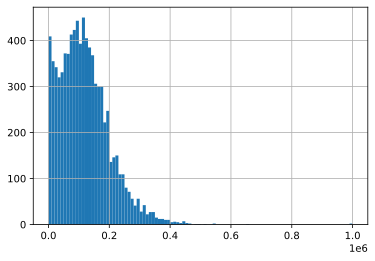

In [30]:
data['mileage'].hist(bins=100)


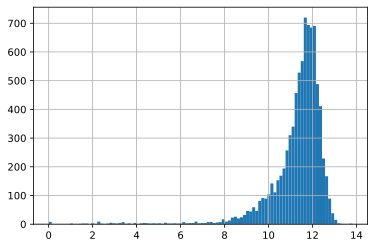

In [31]:
np.log(data['mileage']).hist(bins=100)

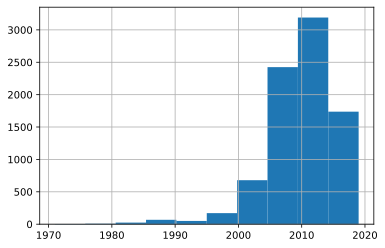

In [32]:
data['modelDate'].hist()

In [33]:
data['modelDate'] = 2021 - data['modelDate']

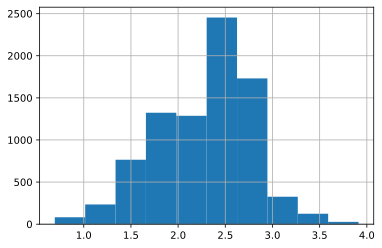

In [34]:
np.log(data['modelDate']).hist()

In [35]:
data['model_info'].value_counts()

5ER         776
3ER         578
X5          501
E_KLASSE    490
A6          433
           ... 
Z8            1
X3_M          1
None          1
CITAN         1
Z1            1
Name: model_info, Length: 122, dtype: int64

In [36]:
# много странностей, надо детальнее осмотреться

In [37]:
data[data['model_info'] == '100']['description']

6275    Продаю S4 1994 года, последний год выпуска S4 ...
Name: description, dtype: object

In [38]:
data[data['model_info'] == 'COUPE']['description']

1646    Собственник 10 лет в одних руках. Есть вся ист...
Name: description, dtype: object

In [39]:
data[data['model_info'] == 'None']

,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_info,...,sell_id,vehicleConfiguration,vehicleTransmission,Владельцы,Владение,ПТС,Привод,Руль,sample,price
2803,седан,MERCEDES,серый,Автомобиль в очень хорошем состоянии. Богатая ...,4000.0,510.0,бензин,41000,7,None,...,1099323364,SEDAN AUTOMATIC 4.0,автоматическая,3 или более,NaN,Дубликат,задний,Левый,1,3700000.0


In [40]:
# проведем модификацию
data.loc[data['model_info'] == '100', 'model_info'] = 'S4'
data.loc[data['model_info'] == 'COUPE', 'model_info'] = 'S2'
data.loc[data['model_info'] == 'None', 'model_info'] = 'C_KLASSE_AMG'

In [41]:
data['name']

0                    300 3.0 AT (220 л.с.)
1       640d xDrive 3.0d AT (313 л.с.) 4WD
2              325xi 2.5 AT (218 л.с.) 4WD
3                   318i 2.0 AT (136 л.с.)
4       520d xDrive 2.0d AT (190 л.с.) 4WD
                       ...                
8348                320i 2.0 AT (150 л.с.)
8349               520d 2.0d AT (190 л.с.)
8350                318i 2.0 AT (143 л.с.)
8351            Long 3.0 AT (310 л.с.) 4WD
8352             Pullman 6.0 AT (394 л.с.)
Name: name, Length: 8353, dtype: object

In [42]:
# смысла в ней мало, потом удалим

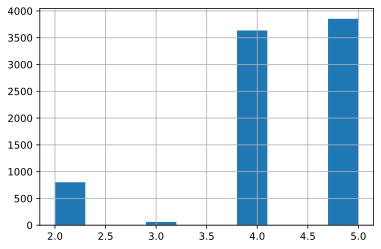

In [43]:
data['numberOfDoors'].hist()

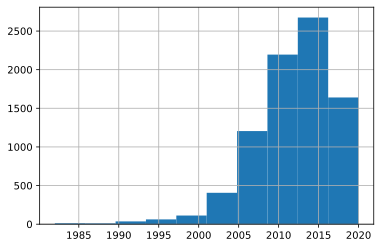

In [44]:
data['productionDate'].hist()

In [45]:
data['productionDate'] = 2021 - data['productionDate']

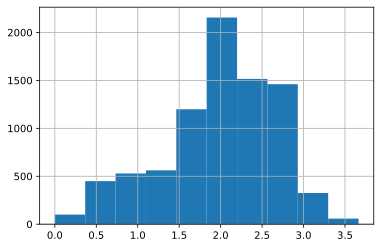

In [46]:
np.log(data['productionDate']).hist()

In [47]:
data['sell_id']


0       1099427284
1       1096405886
2       1100195294
3       1099827282
4       1100076198
           ...    
8348    1100036650
8349    1090506038
8350    1095155628
8351    1099625256
8352    1097146066
Name: sell_id, Length: 8353, dtype: int64

In [48]:
# тоже удалим

In [49]:
data['vehicleConfiguration']

0       WAGON_5_DOORS AUTOMATIC 3.0
1               COUPE AUTOMATIC 3.0
2               COUPE AUTOMATIC 2.5
3               SEDAN AUTOMATIC 2.0
4               SEDAN AUTOMATIC 2.0
                   ...             
8348            SEDAN AUTOMATIC 2.0
8349            SEDAN AUTOMATIC 2.0
8350            SEDAN AUTOMATIC 2.0
8351            SEDAN AUTOMATIC 3.0
8352        LIMOUSINE AUTOMATIC 6.0
Name: vehicleConfiguration, Length: 8353, dtype: object

In [50]:
# и это

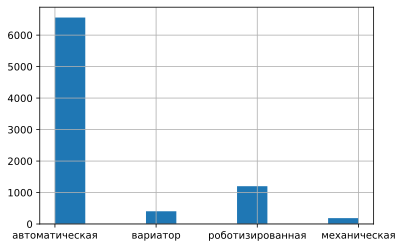

In [51]:
data['vehicleTransmission'].hist()

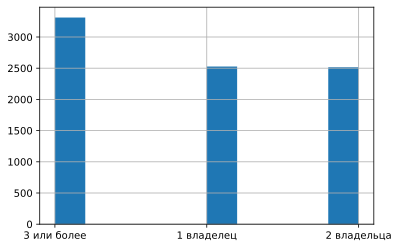

In [52]:
data['Владельцы'].hist()

In [53]:
# сделаем категориальными
owners_dict = {
    '1\xa0владелец': 1,
    '2\xa0владельца': 2,
    '3 или более': 3
}

data['Владельцы'] = data['Владельцы'].map(owners_dict)

In [54]:
data['Владельцы'].value_counts()

3    3312
1    2526
2    2515
Name: Владельцы, dtype: int64

In [55]:
data['Владение'].value_counts(dropna=False)

NaN                    5418
1 год и 8 месяцев        67
1 год и 2 месяца         67
1 год                    55
1 год и 10 месяцев       52
                       ... 
27 лет и 10 месяцев       1
18 лет и 10 месяцев       1
14 лет и 8 месяцев        1
17 лет и 11 месяцев       1
15 лет и 10 месяцев       1
Name: Владение, Length: 181, dtype: int64

Слишком много пропусков, думаю удалить

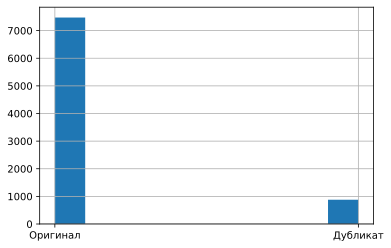

In [56]:
data['ПТС'].hist()

In [57]:
passport_dict = {
    'Дубликат': 0,
    'Оригинал': 1,
}

data['ПТС'] = data['ПТС'].map(passport_dict)

In [58]:
data['ПТС'].value_counts()

1    7474
0     879
Name: ПТС, dtype: int64

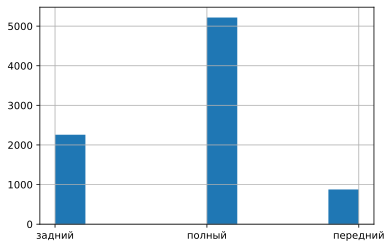

In [59]:
data['Привод'].hist()

In [60]:
data['Руль'].value_counts()

Левый     8351
Правый       2
Name: Руль, dtype: int64

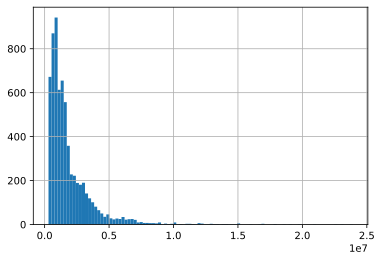

In [61]:
train['price'].hist(bins=100)

# Создадим новые признаки

In [62]:
# смело можно пройтись по цветам
popular_colors = [
    'чёрный', 
    'белый', 
    'серый', 
    'синий'
]

rare_colors = [
    'серебристый',
    'коричневый',
    'красный'
]

data['popular_color'] = 0
data['rare_color'] = 0
data['very_rare_color'] = 0

In [63]:
counter = 0

for color in data['color']:
    if color in popular_colors:
        data.at[counter,'popular_color'] = 1
        counter += 1
    elif color in rare_colors:
        data.at[counter,'rare_color'] = 1
        counter += 1
    else:
        data.at[counter,'very_rare_color'] = 1
        counter += 1

In [64]:
# пробег за год
data['mileage_to_age'] = data['mileage']/data['productionDate']

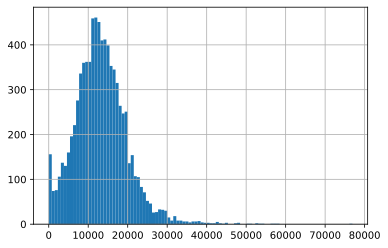

In [65]:
data['mileage_to_age'].hist(bins=100)

In [66]:
# ну и сделаем некоторую категорию
data['low_MtA'] = 0
data['high_MtA'] = 0

In [67]:
counter = 0

for MtA in data['mileage_to_age']:
    if MtA < 5000:
        data.at[counter,'low_MtA'] = 1
        counter += 1
    elif MtA > 30000:
        data.at[counter,'high_MtA'] = 1
        counter += 1
    else:
        counter += 1

# Распределим столбцы по типу

In [68]:
categorical_features = [
    'bodyType', 
    'brand', 
    'color',
    'fuelType', 
    'model_info',
    'vehicleTransmission', 
    'Привод'
]

numerical_features = [
    'engineDisplacement',
    'enginePower',
    'mileage', 
    'modelDate', 
    'productionDate',
    'numberOfDoors',
    'Владельцы',
    'mileage_to_age'
]

binary_features = [
    'popular_color',
    'rare_color'
    'very_rare_color', 
    'low_MtA', 
    'high_MtA',
    'ПТС'
]

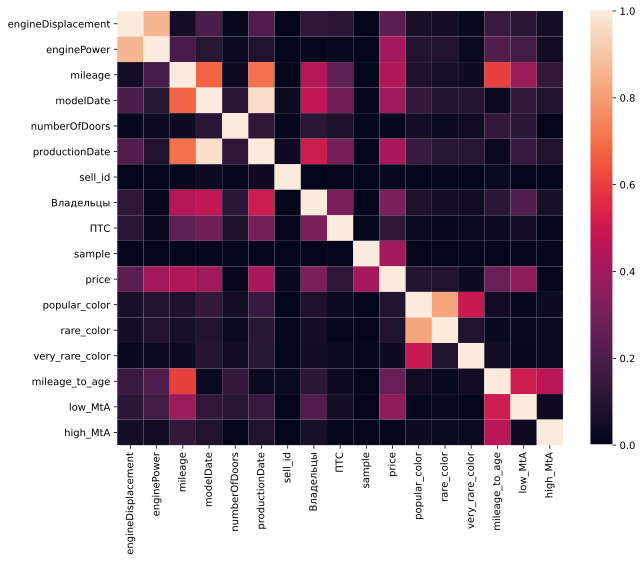

In [69]:
# посмотрим корреляцию
plt.subplots(figsize=(10,8))
sns.heatmap(data.corr().abs(), vmin=0, vmax=1)

In [70]:
data.corr().abs().sort_values(by='price', ascending=False)

,engineDisplacement,enginePower,mileage,modelDate,numberOfDoors,productionDate,sell_id,Владельцы,ПТС,sample,price,popular_color,rare_color,very_rare_color,mileage_to_age,low_MtA,high_MtA
price,0.241048,0.404552,0.436743,0.397267,0.018068,0.417464,0.019779,0.309139,0.118204,0.405771,1.000000,0.090281,0.081155,0.034027,0.269509,0.363177,0.011580
mileage,0.049378,0.184616,1.000000,0.672522,0.038435,0.702970,0.010300,0.444289,0.245004,0.003900,0.436743,0.074997,0.061223,0.037765,0.601572,0.387977,0.132702
productionDate,0.209931,0.085100,0.702970,0.964919,0.124278,1.000000,0.042841,0.507794,0.298051,0.008146,0.417464,0.150023,0.105450,0.101656,0.027846,0.144646,0.083566
sample,0.009001,0.004199,0.003900,0.011782,0.014501,0.008146,0.000134,0.003877,0.008624,1.000000,0.405771,0.003183,0.005860,0.014577,0.003277,0.004362,0.013423
enginePower,0.860317,1.000000,0.184616,0.101825,0.031772,0.085100,0.000859,0.012214,0.019801,0.004199,0.404552,0.089958,0.084783,0.027894,0.209323,0.175343,0.044136
modelDate,0.195373,0.101825,0.672522,1.000000,0.112091,0.964919,0.038045,0.475524,0.285476,0.011782,0.397267,0.136801,0.092767,0.097896,0.023480,0.132525,0.079163
low_MtA,0.110077,0.175343,0.387977,0.132525,0.110394,0.144646,0.005904,0.209073,0.053009,0.004362,0.363177,0.013798,0.022707,0.010606,0.506134,1.000000,0.039769
Владельцы,0.122053,0.012214,0.444289,0.475524,0.112461,0.507794,0.004910,1.000000,0.311522,0.003877,0.309139,0.075965,0.056501,0.046710,0.113091,0.209073,0.066356
mileage_to_age,0.153173,0.209323,0.601572,0.023480,0.130783,0.027846,0.024568,0.113091,0.032032,0.003277,0.269509,0.043919,0.020602,0.045512,1.000000,0.506134,0.456944
engineDisplacement,1.000000,0.860317,0.049378,0.195373,0.011746,0.209931,0.006186,0.122053,0.105635,0.009001,0.241048,0.063556,0.057748,0.023008,0.153173,0.110077,0.048207


In [71]:
# построим боксплоты
def get_boxplot(column):
    fig, ax = plt.subplots(figsize = (10, 14))
    sns.boxplot(x=column, 
                y='price',
                data=train.loc[
                    train.loc[:, column].isin(train.loc[:, column].value_counts().index[:10])
                ],
                ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()

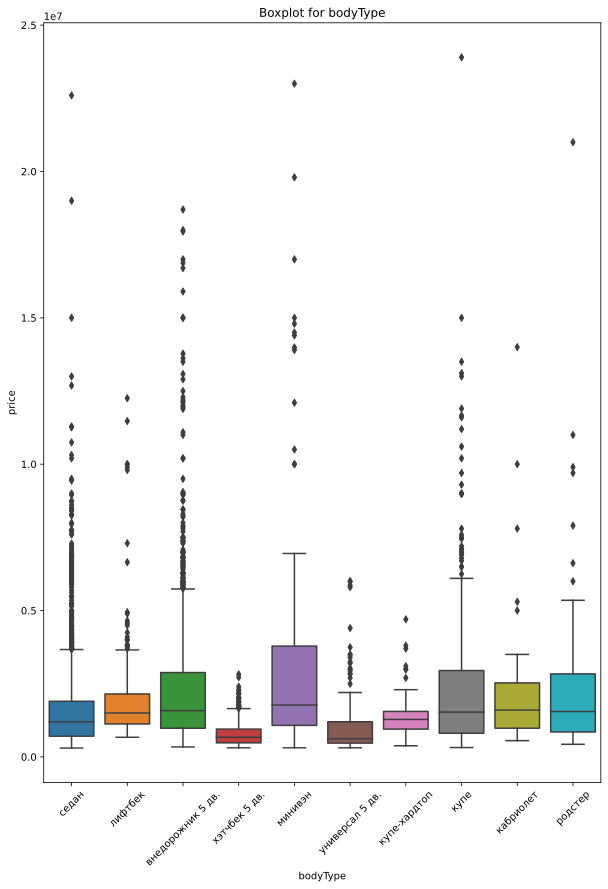

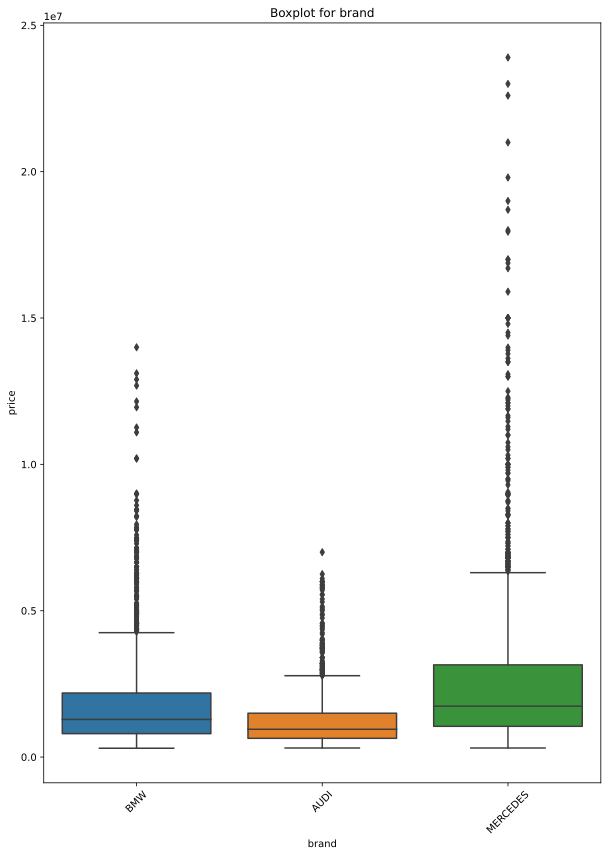

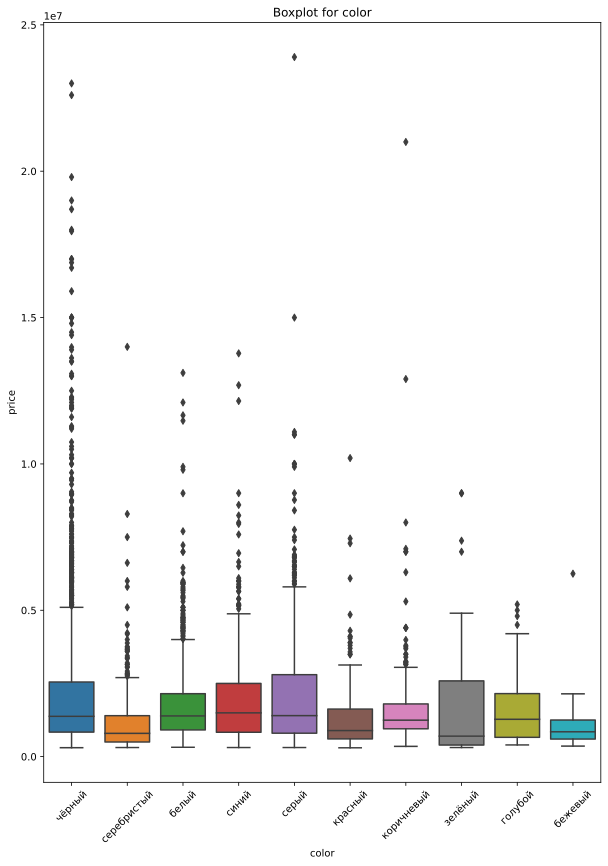

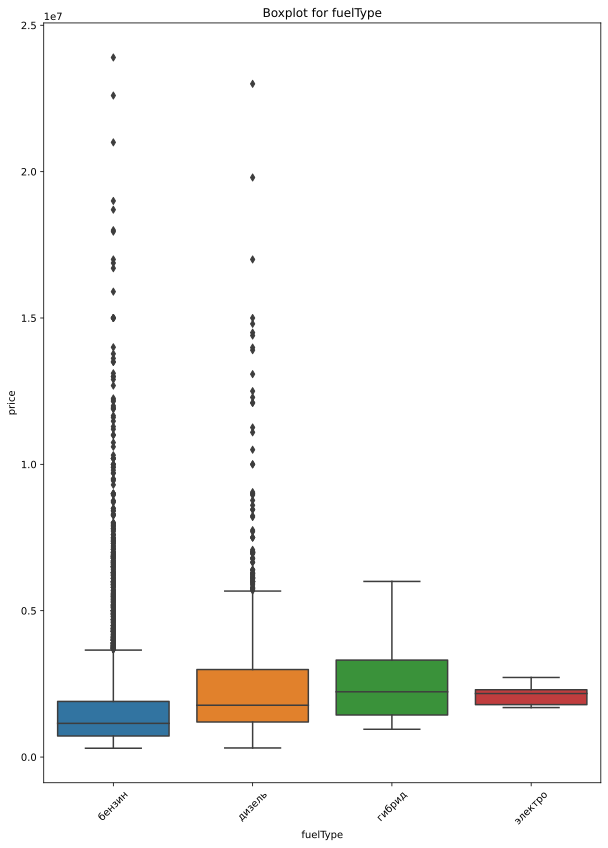

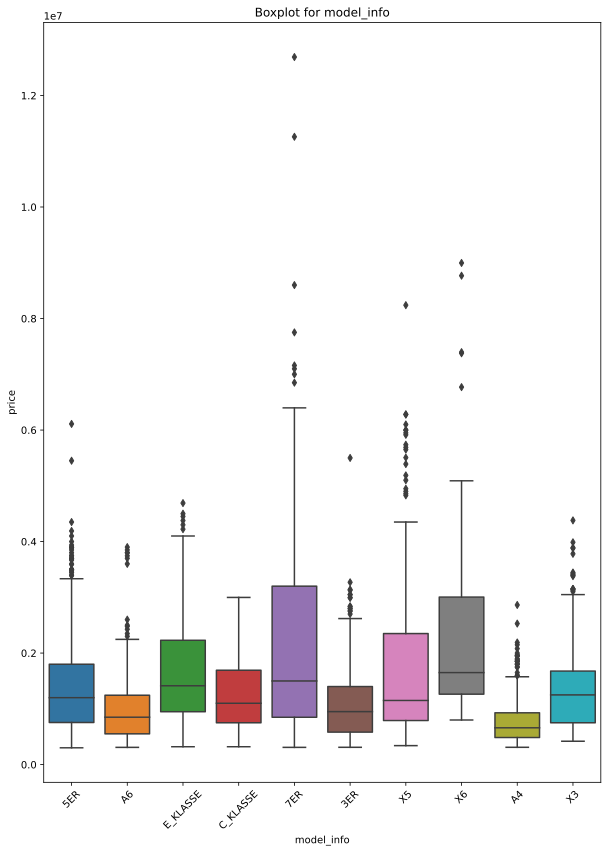

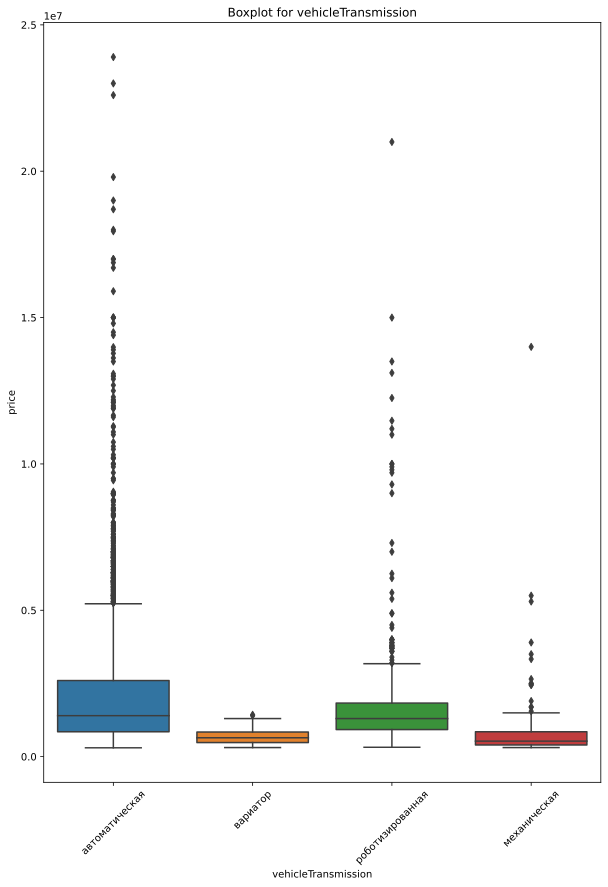

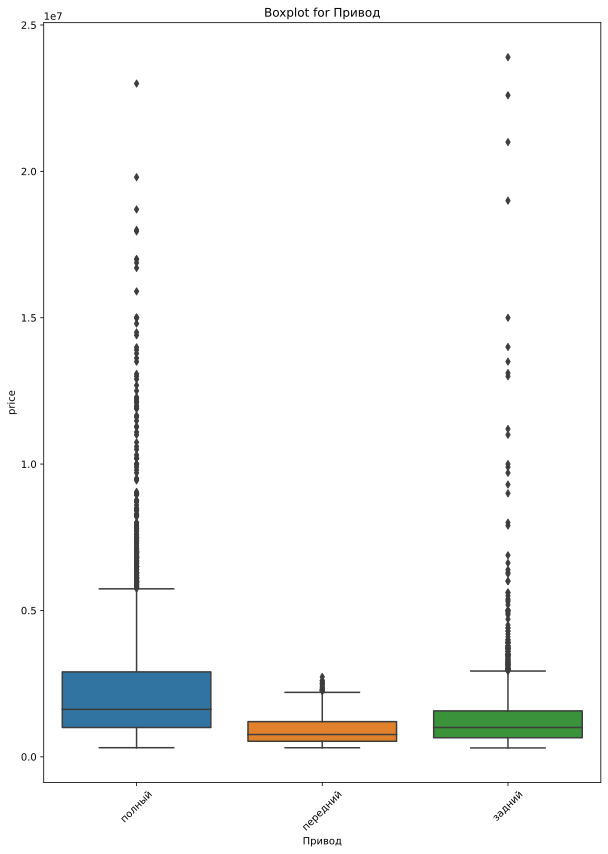

In [72]:
for col in categorical_features:
    get_boxplot(col)

In [73]:
# тест Стьюдента
def get_stat_dif(column):
    cols = train.loc[:, column].value_counts().index[:10]
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(train.loc[train.loc[:, column] == comb[0], 'price'], 
                        train.loc[train.loc[:, column] == comb[1], 'price']).pvalue \
            <= 0.05/len(combinations_all):
            print('Statistically significant differences were found for the column', column)
            break

In [74]:
for col in categorical_features:
    get_stat_dif(col)

Statistically significant differences were found for the column bodyType
Statistically significant differences were found for the column brand
Statistically significant differences were found for the column color
Statistically significant differences were found for the column fuelType
Statistically significant differences were found for the column model_info
Statistically significant differences were found for the column vehicleTransmission
Statistically significant differences were found for the column Привод


Оставим то, что считаем нужным

In [75]:
categorical_features = [
    'bodyType', 
    'brand', 
    'color',
    'fuelType', 
    'model_info',
    'vehicleTransmission', 
    'Привод'
]

numerical_features = [
    'engineDisplacement',
    'enginePower',
    'mileage', 
    'modelDate', 
    'productionDate',
    'numberOfDoors',
    'Владельцы',
    'mileage_to_age'
]

binary_features = [
    'popular_color',
    'rare_color'
    'very_rare_color', 
    'low_MtA', 
    'high_MtA',
    'ПТС'
]

In [76]:
def preproc_data(df_input):

    
    df_output = df_input.copy()
    
    
    df_output.drop([
        'description',
        'name',
        'sell_id',
        'vehicleConfiguration',
        'Владение',
        'Руль'
    ], axis = 1, inplace=True)
    
    
    data['enginePower'] = np.log(data['enginePower'])
    data['mileage'] = np.log(data['mileage'])
    data['engineDisplacement'] = np.log(data['enginePower'])
    data['modelDate'] = np.log(data['mileage'])
    data['productionDate'] = np.log(data['mileage'])
    
    # нормализация
    scaler = MinMaxScaler()
    for column in numerical_features:
        df_output[column] = scaler.fit_transform(df_output[[column]])[:,0]
    
    # One-hot encoding
    for column in categorical_features:
        df_output[column] = df_output[column].astype('category').cat.codes
        
    df_output = pd.get_dummies(
        df_output, 
        columns=categorical_features, 
        dummy_na=False
    )
    
    return df_output

In [77]:
df_preproc = preproc_data(data)

/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [78]:
df_preproc.info()
df_preproc.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8353 entries, 0 to 8352
Columns: 183 entries, engineDisplacement to Привод_2
dtypes: float64(9), int64(7), uint8(167)
memory usage: 2.4 MB


,engineDisplacement,enginePower,mileage,modelDate,numberOfDoors,productionDate,Владельцы,ПТС,sample,price,...,model_info_117,model_info_118,model_info_119,vehicleTransmission_0,vehicleTransmission_1,vehicleTransmission_2,vehicleTransmission_3,Привод_0,Привод_1,Привод_2
0,0.389831,0.2320,0.349999,0.729167,1.000000,0.763158,1.0,1,0,0.0,...,0,0,0,1,0,0,0,1,0,0
1,0.389831,0.3808,0.014999,0.166667,0.000000,0.184211,0.0,1,0,0.0,...,0,0,0,1,0,0,0,0,0,1
2,0.305085,0.2288,0.166599,0.291667,0.000000,0.315789,1.0,1,0,0.0,...,0,0,0,1,0,0,0,0,0,1
3,0.220339,0.0976,0.146999,0.291667,0.666667,0.342105,0.5,1,0,0.0,...,0,0,0,1,0,0,0,1,0,0
4,0.220339,0.1840,0.023999,0.062500,0.666667,0.026316,0.0,1,0,0.0,...,0,0,0,1,0,0,0,0,0,1


## Catboost model

In [79]:
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.price.values
X = train_data.drop(['price'], axis=1)
X_sub = test_data.drop(['price'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, shuffle=True, random_state=RANDOM_SEED
)

In [80]:
# CatBoost training.
model = CatBoostRegressor(
    iterations=8000,
    random_seed=RANDOM_SEED,
    eval_metric='MAPE',
    custom_metric=['RMSE', 'MAE'],
    od_wait=500
)
                          
model.fit(
    X_train,
    y_train,
    eval_set=(X_test, y_test),
    verbose_eval=100,
    use_best_model=True
)

test_predict_catboost = model.predict(X_test)
print(f"TEST mape: {(mape(y_test, test_predict_catboost))*100:0.2f}%")

Learning rate set to 0.017515
0:	learn: 0.9913318	test: 1.0156533	best: 1.0156533 (0)	total: 53.4ms	remaining: 7m 6s
100:	learn: 0.3561095	test: 0.3579898	best: 0.3579898 (100)	total: 417ms	remaining: 32.6s
200:	learn: 0.2546590	test: 0.2534528	best: 0.2534528 (200)	total: 758ms	remaining: 29.4s
300:	learn: 0.2199972	test: 0.2180206	best: 0.2180206 (300)	total: 1.09s	remaining: 27.9s
400:	learn: 0.1946912	test: 0.1947151	best: 0.1947151 (400)	total: 1.42s	remaining: 27s
500:	learn: 0.1807983	test: 0.1823781	best: 0.1823781 (500)	total: 1.76s	remaining: 26.3s
600:	learn: 0.1739417	test: 0.1760098	best: 0.1760098 (600)	total: 2.1s	remaining: 25.9s
700:	learn: 0.1674728	test: 0.1705994	best: 0.1705994 (700)	total: 2.44s	remaining: 25.4s
800:	learn: 0.1618663	test: 0.1648844	best: 0.1648844 (800)	total: 2.78s	remaining: 25s
900:	learn: 0.1563091	test: 0.1595056	best: 0.1595056 (900)	total: 3.12s	remaining: 24.6s
1000:	learn: 0.1516470	test: 0.1562451	best: 0.1562451 (1000)	total: 3.46s	rem

In [81]:
sub_predict_catboost = model.predict(X_sub)
sample_submission['price'] = sub_predict_catboost
sample_submission.to_csv('catboost_submission.csv', index=False)

## Tabular NN

In [82]:
X_train.head()

,engineDisplacement,enginePower,mileage,modelDate,numberOfDoors,productionDate,Владельцы,ПТС,popular_color,rare_color,...,model_info_117,model_info_118,model_info_119,vehicleTransmission_0,vehicleTransmission_1,vehicleTransmission_2,vehicleTransmission_3,Привод_0,Привод_1,Привод_2
7320,0.898305,0.7504,0.149999,0.229167,0.666667,0.236842,0.0,1,1,0,...,0,0,0,1,0,0,0,1,0,0
8037,0.220339,0.2720,0.020941,0.062500,1.000000,0.052632,0.0,1,1,0,...,0,0,0,1,0,0,0,0,0,1
4681,0.406780,0.2880,0.133896,0.312500,0.666667,0.368421,1.0,1,1,0,...,0,0,0,1,0,0,0,0,0,1
6014,0.186441,0.1744,0.329999,0.270833,0.666667,0.342105,1.0,1,1,0,...,0,0,0,1,0,0,0,1,0,0
3649,0.389831,0.3808,0.125999,0.166667,0.666667,0.184211,0.0,1,1,0,...,0,0,0,1,0,0,0,0,0,1


In [83]:
model = Sequential()

model.add(L.Dense(
    512, 
    input_dim=X_train.shape[1], 
    kernel_regularizer=regularizers.l1_l2(
        l1=0.000000001, 
        l2=0.000000001
    ), 
    activation="relu"
))

model.add(L.Dropout(0.5))

model.add(L.Dense(
    256,
    kernel_regularizer=regularizers.l1_l2(
        l1=0.000000001, 
        l2=0.000000001
    ), 
    activation="relu"
))

model.add(L.Dropout(0.5))

model.add(L.Dense(1, activation="linear"))

In [84]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               93184     
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 224,769
Trainable params: 224,769
Non-trainable params: 0
_________________________________________________________________


In [85]:
optimizer = tf.keras.optimizers.Adam(0.01)

model.compile(
    loss='MAPE', 
    optimizer=optimizer, 
    metrics=['MAPE']
)

In [86]:
checkpoint = ModelCheckpoint(
    '../working/best_model.hdf5', 
    monitor=['val_MAPE'], 
    verbose=0, 
    mode='min'
)

earlystop = EarlyStopping(
    monitor='val_MAPE', 
    patience=50, 
    restore_best_weights=True
)

callbacks_list = [checkpoint, earlystop]

In [87]:
# обучение
history = model.fit(
    X_train,
    y_train,
    batch_size=512,
    epochs=500,
    validation_data=(X_test, y_test),
    callbacks=callbacks_list,
    verbose=0
)

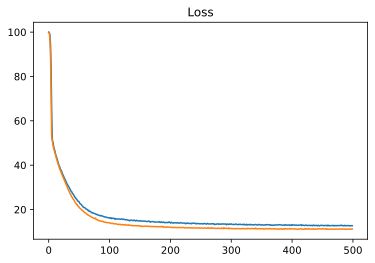

In [88]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [89]:
model.load_weights('../working/best_model.hdf5')
model.save('../working/nn_1.hdf5')

In [90]:
test_predict_nn1 = model.predict(X_test)
print(f"TEST mape: {(mape(y_test, test_predict_nn1[:,0]))*100:0.2f}%")

TEST mape: 11.23%


In [91]:
sub_predict_nn1 = model.predict(X_sub)
sample_submission['price'] = sub_predict_nn1[:,0]
sample_submission.to_csv('nn1_submission.csv', index=False)

## NLP x MLP

In [92]:
data['description']

0       Всем привет!\n\nПродам эксклюзивный проект 124...
1       Продаю любимейшую тачилу.. Обвес и тюнинг Hamm...
2       Машина тут продаётся не в первый раз, НО! Толь...
3       Автомобиль в отличном состоянии, весь в родной...
4       Немка! с бесключивым доступом и камерой заднег...
                              ...                        
8348    Продаётся любимый автомобиль! За годы эксплуат...
8349    Куплена у официального дилера в 2017 г. \n\nТр...
8350    Торг на месте. Все работает. Сборка немецкая. ...
8351    Автомобиль в отличном состоянии.\n3-из Авто в ...
8352    Удлиненный заводской Pullman на базе W140 (воо...
Name: description, Length: 8353, dtype: object

In [93]:
# используем морфи и создадим функцию лемматизации
morph = pymorphy2.MorphAnalyzer()
df_NLP = data.copy()

patterns = "[A-Za-z0-9!#$%&'()*+,./:;<=>?@[\]^_`{|}~—\"\-]+"

def lemmatize(doc):
    doc = re.sub(patterns, ' ', doc)
    tokens = []
    for token in doc.split():
        token = token.strip()
        token = morph.normal_forms(token)[0]
        tokens.append(token)
    return ' '.join(tokens)

In [94]:
df_NLP['description'] = df_NLP.apply(
    lambda df_NLP: lemmatize(df_NLP.description), axis=1)

In [95]:
text_train = data.description.iloc[X_train.index]
text_test = data.description.iloc[X_test.index]
text_sub = data.description.iloc[X_sub.index]

In [96]:
MAX_WORDS = 100000
MAX_SEQUENCE_LENGTH = 256

tokenize = Tokenizer(num_words=MAX_WORDS)
tokenize.fit_on_texts(data.description)

In [97]:
text_train_sequences = sequence.pad_sequences(
    tokenize.texts_to_sequences(text_train), 
    maxlen=MAX_SEQUENCE_LENGTH
)

text_test_sequences = sequence.pad_sequences(
    tokenize.texts_to_sequences(text_test), 
    maxlen=MAX_SEQUENCE_LENGTH
)

text_sub_sequences = sequence.pad_sequences(
    tokenize.texts_to_sequences(text_sub), 
    maxlen=MAX_SEQUENCE_LENGTH
)

print(
    text_train_sequences.shape, 
    text_test_sequences.shape, 
    text_sub_sequences.shape
)

(5679, 256) (1003, 256) (1671, 256)


In [98]:
print(text_train.iloc[6])
print(text_train_sequences[6])

.

• Автомобиль проверен по 110 пунктам
• Автокредит по специальной ставке от 13,7%

Ауди Центр Север, официальный дилер Audi, входящий в группу компаний РОЛЬФ и являющийся одним из крупнейших дилеров в Европе, предлагает Вам ряд услуг по покупке и продаже автомобилей с пробегом.

На протяжении многих лет наш дилерский центр является лидером по продаже автомобилей с пробегом среди всех дилеров Audi в России и предоставляет клиентам самый большой выбор автомобилей с пробегом Audi и других марок.
Каждый автомобиль проходит тщательную диагностику и подготовку, и гарантировано находится в отличном состоянии.
Чтобы убедиться в правильном выборе, у Вас есть возможность пройти тест-драйв ― ознакомительную поездку на интересующем автомобиле.
Вы сможете ознакомиться с автомобилем не выходя из дома – наш менеджер проведет online презентацию и в видеозвонке покажет выбранный автомобиль.
Также Ауди Центр Север представляет уникальное предложение по кредитованию автомобилей с пробегом на индивидуал

In [99]:
model_nlp = Sequential()
model_nlp.add(L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"))
model_nlp.add(L.Embedding(len(tokenize.word_index)+1, MAX_SEQUENCE_LENGTH,))
model_nlp.add(L.LSTM(256, return_sequences=True))
model_nlp.add(L.Dropout(0.5))
model_nlp.add(L.LSTM(128,))
model_nlp.add(L.Dropout(0.25))
model_nlp.add(L.Dense(64, activation="relu"))
model_nlp.add(L.Dropout(0.25))

In [100]:
model_mlp = Sequential()
model_mlp.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
model_mlp.add(L.Dropout(0.5))
model_mlp.add(L.Dense(256, activation="relu"))
model_mlp.add(L.Dropout(0.5))

In [101]:
combinedInput = L.concatenate([model_nlp.output, model_mlp.output])
head = L.Dense(64, activation="relu")(combinedInput)
head = L.Dense(1, activation="linear")(head)
model = Model(inputs=[model_nlp.input, model_mlp.input], outputs=head)

In [102]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
seq_description (InputLayer)    [(None, 256)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 256, 256)     10135552    seq_description[0][0]            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 256, 256)     525312      embedding[0][0]                  
__________________________________________________________________________________________________
dropout_2 (Dropout)             (None, 256, 256)     0           lstm[0][0]                       
_______________________________________________________________________________________

In [103]:
optimizer = tf.keras.optimizers.Adam(0.01)

model.compile(
    loss='MAPE',
    optimizer=optimizer, 
    metrics=['MAPE']
)

In [104]:
checkpoint = ModelCheckpoint(
    '../working/best_model.hdf5', 
    monitor=['val_MAPE'], 
    verbose=0, 
    mode='min'
)

earlystop = EarlyStopping(
    monitor='val_MAPE', 
    patience=10, 
    restore_best_weights=True
)

callbacks_list = [checkpoint, earlystop]

In [105]:
history = model.fit(
    [text_train_sequences, X_train],
    y_train,
    batch_size=512,
    epochs=500,
    validation_data=([text_test_sequences, X_test], y_test),
    callbacks=callbacks_list
)

Epoch 1/500
12/12 [==============================] - 6s 500ms/step - loss: 99.9865 - MAPE: 99.9865 - val_loss: 99.8426 - val_MAPE: 99.8426
Epoch 2/500
12/12 [==============================] - 5s 404ms/step - loss: 98.6051 - MAPE: 98.6051 - val_loss: 93.6011 - val_MAPE: 93.6011
Epoch 3/500
12/12 [==============================] - 5s 439ms/step - loss: 79.0918 - MAPE: 79.0918 - val_loss: 51.9818 - val_MAPE: 51.9818
Epoch 4/500
12/12 [==============================] - 5s 406ms/step - loss: 54.1895 - MAPE: 54.1895 - val_loss: 49.7211 - val_MAPE: 49.7211
Epoch 5/500
12/12 [==============================] - 5s 418ms/step - loss: 49.3169 - MAPE: 49.3169 - val_loss: 47.4830 - val_MAPE: 47.4830
Epoch 6/500
12/12 [==============================] - 5s 404ms/step - loss: 46.1945 - MAPE: 46.1945 - val_loss: 44.8528 - val_MAPE: 44.8528
Epoch 7/500
12/12 [==============================] - 5s 414ms/step - loss: 43.7425 - MAPE: 43.7425 - val_loss: 42.4921 - val_MAPE: 42.4921
Epoch 8/500
12/12 [========

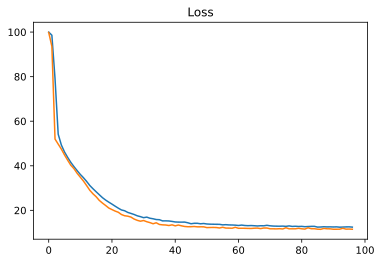

In [106]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [107]:
model.load_weights('../working/best_model.hdf5')
model.save('../working/nn_mlp_nlp.hdf5')

In [108]:
test_predict_nn2 = model.predict([text_test_sequences, X_test])
print(f"TEST mape: {(mape(y_test, test_predict_nn2[:,0]))*100:0.2f}%")

TEST mape: 11.51%


In [109]:
sub_predict_nn2 = model.predict([text_sub_sequences, X_sub])
sample_submission['price'] = sub_predict_nn2[:,0]
sample_submission.to_csv('nn2_submission.csv', index=False)

## Модель для добавления картинок

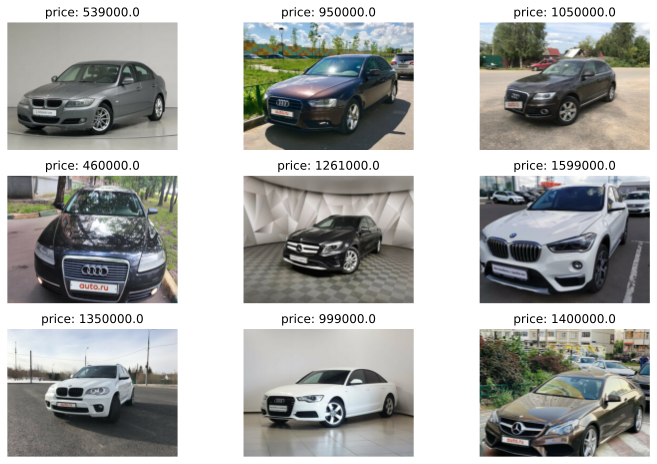

In [110]:
plt.figure(figsize = (12,8))

random_image = train.sample(n = 9)
random_image_paths = random_image['sell_id'].values
random_image_cat = random_image['price'].values

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(DATA_DIR + 'img/img/' + str(path) + '.jpg')
    plt.subplot(3, 3, index + 1)
    plt.imshow(im)
    plt.title('price: ' + str(random_image_cat[index]))
    plt.axis('off')
plt.show()

In [111]:
size = (320, 240)

def get_image_array(index):
    images_train = []
    for index, sell_id in enumerate(data['sell_id'].iloc[index].values):
        image = cv2.imread(DATA_DIR + 'img/img/' + str(sell_id) + '.jpg')
        assert(image is not None)
        image = cv2.resize(image, size)
        images_train.append(image)
    images_train = np.array(images_train)
    print('images shape', images_train.shape, 'dtype', images_train.dtype)
    return(images_train)

images_train = get_image_array(X_train.index)
images_test = get_image_array(X_test.index)
images_sub = get_image_array(X_sub.index)

images shape (5679, 240, 320, 3) dtype uint8
images shape (1003, 240, 320, 3) dtype uint8
images shape (1671, 240, 320, 3) dtype uint8


In [112]:
from albumentations import (
    HorizontalFlip, 
    IAAPerspective, 
    ShiftScaleRotate, 
    CLAHE, 
    RandomRotate90,
    Transpose,
    ShiftScaleRotate, 
    Blur, 
    OpticalDistortion, 
    GridDistortion, 
    HueSaturationValue,
    IAAAdditiveGaussianNoise, 
    GaussNoise, 
    MotionBlur, 
    MedianBlur, 
    IAAPiecewiseAffine,
    IAASharpen, 
    IAAEmboss, 
    RandomBrightnessContrast, 
    Flip, 
    OneOf, 
    Compose
)

In [113]:
augmentation = Compose([
    HorizontalFlip(),
    OneOf([
        IAAAdditiveGaussianNoise(),
        GaussNoise(),
    ], p=0.2),
    OneOf([
        MotionBlur(p=0.2),
        MedianBlur(blur_limit=3, p=0.1),
        Blur(blur_limit=3, p=0.1),
    ], p=0.2),
    ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.3, rotate_limit=15, p=1),
    OneOf([
        OpticalDistortion(p=0.2),
        GridDistortion(p=0.1),
        IAAPiecewiseAffine(p=0.2),
    ], p=0.2),
    OneOf([
        CLAHE(clip_limit=2),
        IAASharpen(),
        IAAEmboss(),
        RandomBrightnessContrast(),
    ], p=0.3),
    HueSaturationValue(p=0.2),
], p=1)

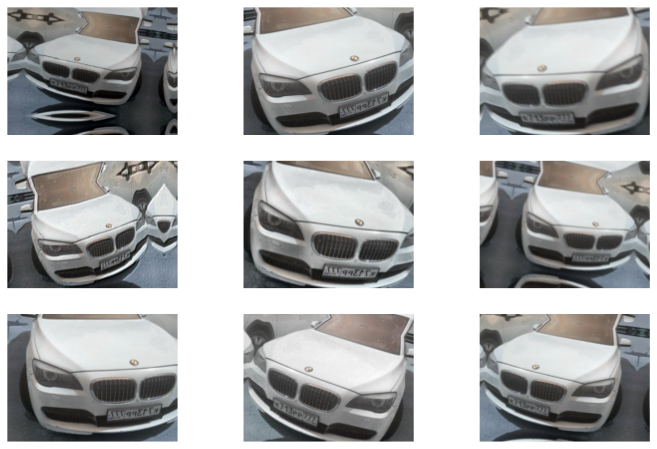

In [114]:
plt.figure(figsize = (12,8))
for i in range(9):
    img = augmentation(image = images_train[0])['image']
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

In [115]:
def make_augmentations(images):
    augmented_images = np.empty(images.shape)
    for i in range(images.shape[0]):
        if i % 200 == 0:
            print('.', end = '')
        augment_dict = augmentation(image = images[i])
        augmented_image = augment_dict['image']
        augmented_images[i] = augmented_image
    print('')
    return augmented_images

In [116]:
tokenize = Tokenizer(num_words=MAX_WORDS)
tokenize.fit_on_texts(data.description)

In [117]:
# обернем наши дела в функции
def process_image(image):
    return augmentation(image = image.numpy())['image']

def tokenize_(descriptions):
    return sequence.pad_sequences(
        tokenize.texts_to_sequences(descriptions), 
        maxlen = MAX_SEQUENCE_LENGTH
    )

def tokenize_text(text):
    return tokenize_([text.numpy().decode('utf-8')])[0]

def tf_process_train_dataset_element(image, table_data, text, price):
    im_shape = image.shape
    [image,] = tf.py_function(process_image, [image], [tf.uint8])
    image.set_shape(im_shape)
    [text,] = tf.py_function(tokenize_text, [text], [tf.int32])
    return (image, table_data, text), price

def tf_process_val_dataset_element(image, table_data, text, price):
    [text,] = tf.py_function(tokenize_text, [text], [tf.int32])
    return (image, table_data, text), price

In [118]:
train_dataset = tf.data.Dataset.from_tensor_slices((
    images_train, 
    X_train, 
    data.description.iloc[X_train.index], 
    y_train
)).map(tf_process_train_dataset_element)

test_dataset = tf.data.Dataset.from_tensor_slices((
    images_test, 
    X_test, 
    data.description.iloc[X_test.index], 
    y_test
)).map(tf_process_val_dataset_element)

y_sub = np.zeros(len(X_sub))
sub_dataset = tf.data.Dataset.from_tensor_slices((
    images_sub, 
    X_sub, 
    data.description.iloc[X_sub.index], 
    y_sub
)).map(tf_process_val_dataset_element)

In [119]:
train_dataset.__iter__().__next__();
test_dataset.__iter__().__next__();
sub_dataset.__iter__().__next__();

In [120]:
efficientnet_model = tf.keras.applications.efficientnet.EfficientNetB3(
    weights = 'imagenet', 
    include_top = False, 
    input_shape = (size[1], size[0], 3)
)

efficientnet_output = L.GlobalAveragePooling2D()(
    efficientnet_model.output
)

43941888/43941136 [==============================] - 1s 0us/step


In [121]:
# используем Fine-tuning
fine_tune_at = len(efficientnet_model.layers)//2

for layer in efficientnet_model.layers[:fine_tune_at]:
    layer.trainable =  False

In [122]:
tabular_model = Sequential([
    L.Input(shape = X.shape[1]),
    L.Dense(512, activation = 'relu'),
    L.Dropout(0.5),
    L.Dense(256, activation = 'relu'),
    L.Dropout(0.5),
    ])

In [123]:
nlp_model = Sequential([
    L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"),
    L.Embedding(len(tokenize.word_index)+1, MAX_SEQUENCE_LENGTH),
    L.LSTM(256, return_sequences=True),
    L.Dropout(0.5),
    L.LSTM(128),
    L.Dropout(0.25),
    L.Dense(64),
    ])

In [124]:
combinedInput = L.concatenate([
    efficientnet_output, 
    tabular_model.output, 
    nlp_model.output
])

head = L.Dense(256, activation="relu")(combinedInput)
head = L.Dense(1,)(head)

model = Model(inputs=[
    efficientnet_model.input, 
    tabular_model.input, 
    nlp_model.input
], outputs=head)

In [125]:
optimizer = tf.keras.optimizers.Adam(0.005)

model.compile(
    loss='MAPE',
    optimizer=optimizer,
    metrics=['MAPE']
)

In [126]:
checkpoint = ModelCheckpoint(
    '../working/best_model.hdf5', 
    monitor=['val_MAPE'], 
    verbose=0, 
    mode='min'
)

earlystop = EarlyStopping(
    monitor='val_MAPE', 
    patience=10, 
    restore_best_weights=True
)

callbacks_list = [checkpoint, earlystop]

In [127]:
history = model.fit(
    train_dataset.batch(30),
    epochs=100,
    validation_data=test_dataset.batch(30),
    callbacks=callbacks_list
)

Epoch 1/100
190/190 [==============================] - 120s 630ms/step - loss: 56.6227 - MAPE: 56.6227 - val_loss: 40.9228 - val_MAPE: 40.9228
Epoch 2/100
190/190 [==============================] - 115s 605ms/step - loss: 33.4006 - MAPE: 33.4006 - val_loss: 26.1247 - val_MAPE: 26.1247
Epoch 3/100
190/190 [==============================] - 116s 609ms/step - loss: 25.0297 - MAPE: 25.0297 - val_loss: 20.9464 - val_MAPE: 20.9464
Epoch 4/100
190/190 [==============================] - 113s 595ms/step - loss: 20.5093 - MAPE: 20.5093 - val_loss: 16.9056 - val_MAPE: 16.9056
Epoch 5/100
190/190 [==============================] - 115s 607ms/step - loss: 17.5752 - MAPE: 17.5752 - val_loss: 14.5090 - val_MAPE: 14.5090
Epoch 6/100
190/190 [==============================] - 116s 610ms/step - loss: 16.3076 - MAPE: 16.3076 - val_loss: 13.9157 - val_MAPE: 13.9157
Epoch 7/100
190/190 [==============================] - 115s 606ms/step - loss: 15.1814 - MAPE: 15.1814 - val_loss: 13.0965 - val_MAPE: 13.0965

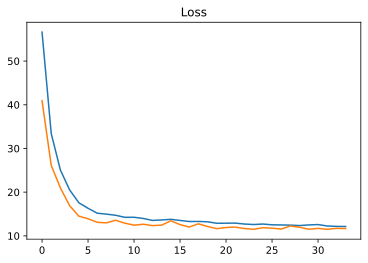

In [128]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [129]:
model.load_weights('../working/best_model.hdf5')
model.save('../working/nn_final.hdf5')

In [130]:
test_predict_nn3 = model.predict(test_dataset.batch(30))
print(f"TEST mape: {(mape(y_test, test_predict_nn3[:,0]))*100:0.2f}%")

TEST mape: 11.68%


In [131]:
sub_predict_nn3 = model.predict(sub_dataset.batch(30))
sample_submission['price'] = sub_predict_nn3[:,0]
sample_submission.to_csv('nn3_submission.csv', index=False)

## Blending

In [132]:
# Объеденим наши сети и посмотрим, стало ли лучше
blend_predict = (test_predict_catboost + test_predict_nn3[:,0]) / 2
print(f"TEST mape: {(mape(y_test, blend_predict))*100:0.2f}%")

TEST mape: 10.91%


In [133]:
# финальный сабмишн
blend_sub_predict = (sub_predict_catboost + sub_predict_nn3[:,0]) / 2
sample_submission['price'] = blend_sub_predict
sample_submission.to_csv('blend_submission.csv', index=False)